In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)

# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

# Add the document chunks to the "vector store" using NomicEmbeddings
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
    #embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever(k=4)

In [19]:
retriever.invoke("What is agent?")

[Document(metadata={'id': 'cc9367ba-a4d1-4b15-93ac-899e6d975559', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='Weng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.'),
 Document(metadata={'id': '48817582-d32a-45ac-b039-23b3efbfbe3b', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Po

In [21]:
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [6]:
from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

llm = ChatOllama(
    model="llama3.1",
    temperature=0,
)

rag_chain = prompt | llm | StrOutputParser()

In [22]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

# JSON
llm = ChatOllama(model="llama3.1", format="json", temperature=0)


prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()

In [23]:
from typing_extensions import TypedDict, List
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


# Vectorstore 에서 문서를 검색하는 노드
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


# rag_chain 을 호출해서 답변을 생성하는 노드
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }

# 문서의 관련성을 평가하는 노드
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }

# 웹 검색을 수행하는 노드
def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

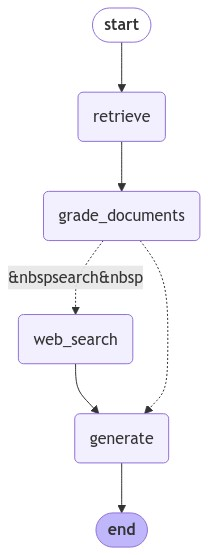

In [24]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [29]:
import uuid


def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}

    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )

    return {"response": state_dict["generation"], "steps": state_dict["steps"]}


example = {"input": "What is LangGraph?"}
response = predict_custom_agent_answer(example)
response

{'response': 'LangGraph is a framework for building stateful, multi-actor agents with LLMs that can handle complex scenarios and collaborate with humans. It offers extensive customization options and is seamlessly integrated into the LangChain ecosystem. LangGraph allows users to create stateful, flexible, and scalable systems using nodes, edges, and state management.',
 'steps': ['retrieve_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}